In [31]:
import scanpy as sc
import scanpy.external as sce

import anndata
from pathlib import Path
from tqdm import tqdm
import pandas as pd

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from upsetplot import UpSet
from upsetplot import from_contents

In [33]:
#import relation_data_lake as rdl

In [34]:
from scipy import stats

In [35]:
import scipy.sparse as sp
import anndata as ad

In [36]:
import json

import dask.dataframe as dd
import numpy as np
import pandas as pd
#import relation_data_lake as rdl
import scanpy as sc
import scipy.sparse as sp
from anndata import AnnData
#from relation_data_lake.aws.aws_api import pull_folder

In [37]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=400, figsize = [1.5*6.4, 1.5*4.8])
sns.set_style("whitegrid")

In [38]:
n_jobs = 50

sc._settings.ScanpyConfig(
    n_jobs=n_jobs
)

In [39]:
import loompy as lp
import glob
import json
import zlib
import base64

from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

In [40]:
def get_cell_type_proportions_ntc(adata, key):
    tmp = adata[adata.obs.target == 'non-targeting'].obs.copy()
    tmp['Frequency'] = 0
    tmp.Frequency[tmp.condition == 'Il1b'] = 1/tmp[tmp.condition == 'Il1b'].shape[0]
    tmp.Frequency[tmp.condition == 'Resting'] = 1/tmp[tmp.condition == 'Resting'].shape[0]
    tmp.Frequency[tmp.condition == 'Tgfb1'] = 1/tmp[tmp.condition == 'Tgfb1'].shape[0]
    tmp = tmp.groupby([ key, 'condition']).sum()
    tmp = tmp.reset_index()
    tmp.rename(columns={ key: 'Cell Type', 'condition':'Condition'}, inplace=True)
    return tmp

def get_cell_type_proportions_all(adata, key):
    tmp = adata.obs.copy()
    tmp['Frequency'] = 0
    tmp.Frequency[tmp.condition == 'Il1b'] = 1/tmp[tmp.condition == 'Il1b'].shape[0]
    tmp.Frequency[tmp.condition == 'Resting'] = 1/tmp[tmp.condition == 'Resting'].shape[0]
    tmp.Frequency[tmp.condition == 'Tgfb1'] = 1/tmp[tmp.condition == 'Tgfb1'].shape[0]
    tmp = tmp.groupby([ key, 'condition']).sum()
    tmp = tmp.reset_index()
    tmp.rename(columns={ key: 'Cell Type', 'condition':'Condition'}, inplace=True)
    return tmp

In [41]:
def get_cell_type_enrich(adata, key, condition_key):
    
    
    tmp = adata.obs.copy()
    tmp = tmp.groupby(['condition','target',key]).count()
    tmp.reset_index(inplace=True)
    tmp.drop(columns={'n_genes_by_counts','total_counts','total_counts_mt','pct_counts_mt','rep','n_counts','leiden'}, inplace=True)
    tmp.rename(columns={'umap_density_condition':'number_cells'}, inplace=True)

    tmp_R = tmp[tmp.condition == condition_key]
    tmp_R = tmp_R.pivot('target',key, 'number_cells')
    tmp_R = (100*tmp_R.div( tmp_R.sum(axis=1), axis=0) )
    
    tmp_R = tmp_R.div(tmp_R.loc['non-targeting'], axis=1)
    tmp_R.drop(index = 'non-targeting', inplace=True)
    tmp_R = np.log2(tmp_R)
    
    return tmp_R


# Load data and create objects

In [42]:
adata_PS = sc.read_h5ad('/home/jupyter-jake/SharedData/collaborations/lara-fibroblast-mouse/References/Atlas/Mouse_PS_Fibro.h5ad')
adata_SS = sc.read_h5ad('/home/jupyter-jake/SharedData/collaborations/lara-fibroblast-mouse/References/Atlas/Mouse_SS_Fibro.h5ad')


In [43]:
adata_PS = adata_PS[adata_PS.obs.Tissue == 'Heart injury']
adata_PS

View of AnnData object with n_obs × n_vars = 3145 × 21087
    obs: 'nCount_RNA', 'nFeature_RNA', 'Cluster', 'ClustName', 'Tissue'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'harmony', 'umap'

In [44]:
adata_SS = adata_SS[adata_SS.obs.Tissue == 'Heart']
adata_SS

View of AnnData object with n_obs × n_vars = 25492 × 21087
    obs: 'nCount_RNA', 'nFeature_RNA', 'Cluster', 'ClustName', 'Tissue'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'harmony', 'umap'

In [45]:
adata = sc.concat([adata_PS, adata_SS],axis=0)

In [46]:
sc.pp.filter_genes(adata, min_cells=100)
sc.pp.filter_genes(adata, min_counts=1000)
adata

AnnData object with n_obs × n_vars = 28637 × 9066
    obs: 'nCount_RNA', 'nFeature_RNA', 'Cluster', 'ClustName', 'Tissue'
    var: 'n_cells', 'n_counts'
    obsm: 'harmony', 'umap'

In [47]:
f_tfs = "/home/jupyter-jake/SharedData/collaborations/pyscenic/mouse/allTFs_mm.txt" 
f_loom_path_scenic = "/home/jupyter-jake/SharedData/collaborations/lara-fibroblast-mouse/References/Atlas/Mouse_Comb_Fibro.loom"
f_db_glob = "/home/jupyter-jake/SharedData/collaborations/pyscenic/mouse/*feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path = "/home/jupyter-jake/SharedData/collaborations/pyscenic/mouse/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl"
f_pyscenic_output = "pyscenic_output_Comb.loom"


In [18]:
Stopstoptop

NameError: name 'Stopstoptop' is not defined

In [19]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

In [ ]:
!pyscenic grn {f_loom_path_scenic} {f_tfs} -o adj_Comb.csv --num_workers 20

In [24]:
!pyscenic ctx adj_Comb.csv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output reg_Comb.csv \
    --mask_dropouts \
    --num_workers 20


2023-07-19 12:33:29,542 - pyscenic.cli.pyscenic - INFO - Creating modules.

2023-07-19 12:33:30,506 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2023-07-19 12:33:35,632 - pyscenic.utils - INFO - Calculating Pearson correlations.

2023-07-19 12:33:36,025 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2023-07-19 12:34:01,674 - pyscenic.utils - INFO - Creating modules.

2023-07-19 12:34:57,910 - pyscenic.cli.pyscenic - IN

In [25]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    reg_Comb.csv \
    --output {f_pyscenic_output} \
    --num_workers 20


2023-07-19 13:19:20,058 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2023-07-19 13:19:28,249 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2023-07-19 13:19:31,905 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2023-07-19 13:19:53,570 - pyscenic.cli.pyscenic - INFO - Writing results to file.
/opt/tljh/user/envs/jake_sc_eda/lib/python3.10/site-packages/pyscenic/cli/utils.py:347: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, threshold in auc_thresholds.iteritems()


In [ ]:
dgsdsgfdfds

In [48]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [49]:
auc_mtx

,Ar(+),Arnt(+),Atf1(+),Atf3(+),Atf4(+),Atf5(+),Atf6(+),Atf6b(+),Atf7(+),Bach1(+),...,Zfp710(+),Zfp738(+),Zfp740(+),Zfp777(+),Zfp874a(+),Zfp874b(+),Zfx(+),Zkscan17(+),Zscan21(+),Zscan29(+)
AAACCTGAGTACGACG-1_6,0.264625,0.014501,0.000060,0.105950,0.043380,0.105960,0.000000,0.000000,0.018200,0.019603,...,0.0,0.001176,0.017739,0.0,0.0,0.005151,0.012172,0.0,0.0,0.007085
AAACCTGCACCAACCG-1_6,0.072020,0.011097,0.000000,0.097262,0.034383,0.087196,0.022320,0.000000,0.011085,0.014373,...,0.0,0.000340,0.009371,0.0,0.0,0.000000,0.014431,0.0,0.0,0.008866
AAACGGGAGCTGTCTA-1_6,0.069536,0.016954,0.000000,0.122025,0.047954,0.070640,0.020849,0.000000,0.014305,0.017406,...,0.0,0.004715,0.013082,0.0,0.0,0.000000,0.011574,0.0,0.0,0.010183
AAACGGGAGTGGTAGC-1_6,0.148455,0.010480,0.000000,0.085507,0.039385,0.083885,0.008879,0.000000,0.016836,0.011859,...,0.0,0.001646,0.012676,0.0,0.0,0.000000,0.013600,0.0,0.0,0.015773
AAACGGGCAATCCAAC-1_6,0.238135,0.008830,0.002058,0.114061,0.040594,0.185982,0.000000,0.017920,0.017412,0.011511,...,0.0,0.004781,0.016511,0.0,0.0,0.000000,0.012388,0.0,0.0,0.004807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTATCGCAT-1_25,0.267660,0.017504,0.000000,0.090777,0.035613,0.161700,0.008143,0.011102,0.019804,0.016810,...,0.0,0.002469,0.007022,0.0,0.0,0.000000,0.014847,0.0,0.0,0.011394
TTTGTTGGTCAAAGCG-1_25,0.159768,0.016969,0.000000,0.098403,0.036896,0.339956,0.000000,0.000000,0.019450,0.014558,...,0.0,0.007681,0.009663,0.0,0.0,0.000000,0.018699,0.0,0.0,0.016663
TTTGTTGGTCTAGGCC-1_25,0.320916,0.018619,0.000000,0.100779,0.041535,0.306291,0.007751,0.000000,0.016580,0.019070,...,0.0,0.003370,0.007090,0.0,0.0,0.000000,0.010847,0.0,0.0,0.000000
TTTGTTGGTGCATTAC-1_25,0.235099,0.021094,0.005191,0.090877,0.038155,0.077263,0.007309,0.000000,0.013683,0.013388,...,0.0,0.000052,0.006420,0.0,0.0,0.000000,0.012466,0.0,0.0,0.009044


In [50]:
asdasdas

NameError: name 'asdasdas' is not defined

In [51]:
rss_cellType = regulon_specificity_scores( auc_mtx, adata.obs.Tissue )
rss_cellType

,Ar(+),Arnt(+),Atf1(+),Atf3(+),Atf4(+),Atf5(+),Atf6(+),Atf6b(+),Atf7(+),Bach1(+),...,Zfp710(+),Zfp738(+),Zfp740(+),Zfp777(+),Zfp874a(+),Zfp874b(+),Zfx(+),Zkscan17(+),Zscan21(+),Zscan29(+)
Heart injury,0.249017,0.278178,0.289972,0.292565,0.297477,0.279002,0.300475,0.255700,0.280193,0.278779,...,0.194734,0.270128,0.297847,0.198406,0.185528,0.180361,0.285290,0.177345,0.184534,0.290037
Heart,0.701411,0.787787,0.331754,0.779109,0.776803,0.602554,0.602843,0.358122,0.781620,0.778928,...,0.188850,0.581018,0.764287,0.190064,0.177515,0.183539,0.777543,0.176528,0.176905,0.636732


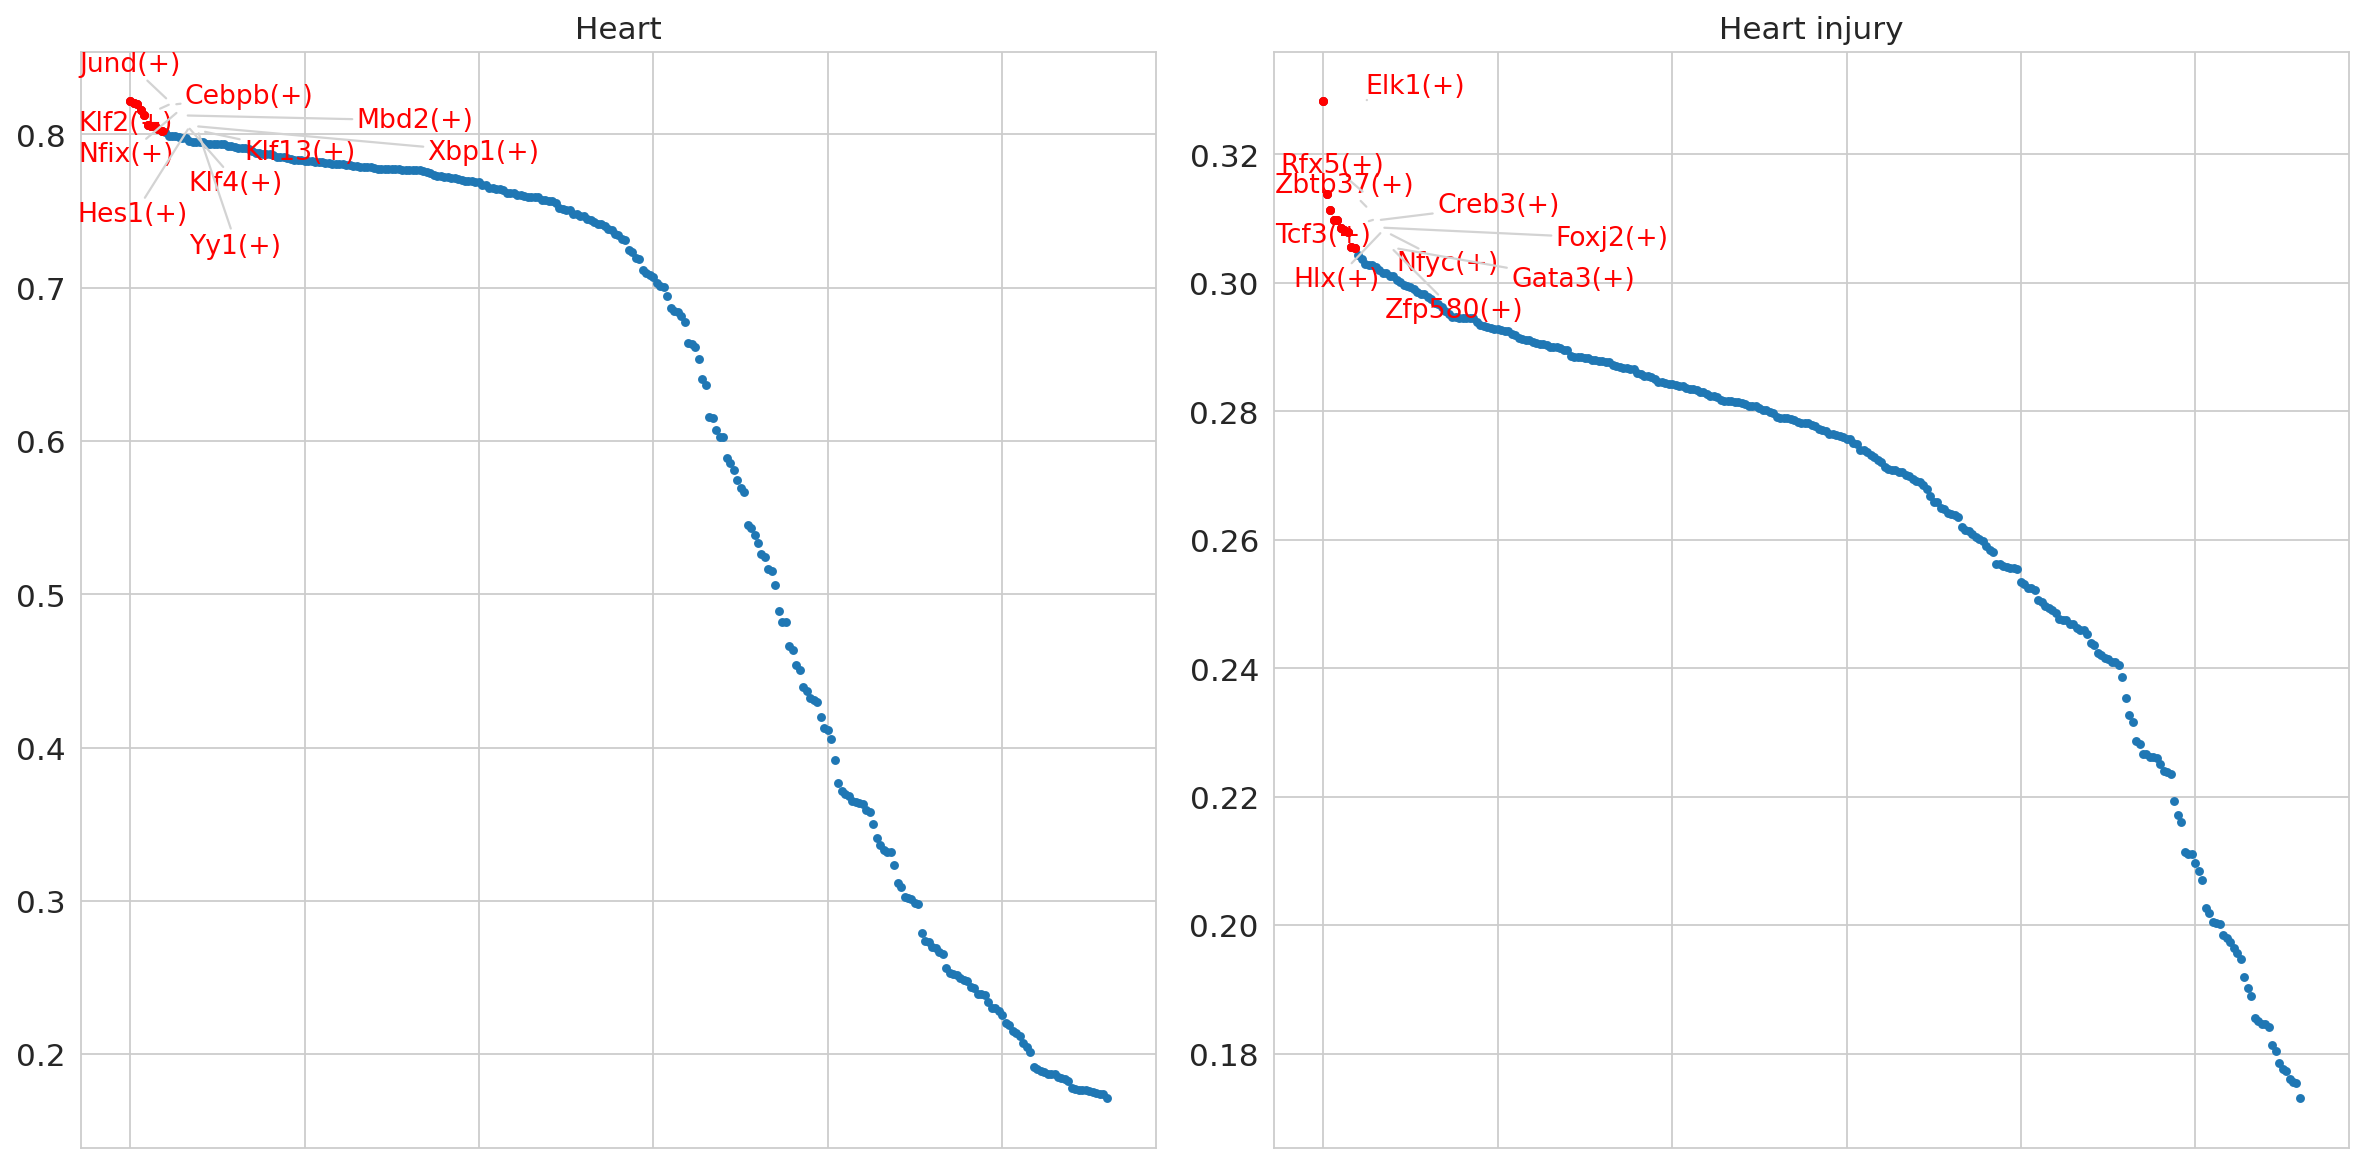

In [66]:
cats = sorted(list(set(adata.obs.Tissue )))

fig = plt.figure(figsize=(15, 7.5))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(1,2,num)
    plot_rss(rss_cellType, c, top_n=10, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
#fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
#fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({'figure.autolayout': True, 'figure.titlesize': 'medium' ,'axes.labelsize': 'medium','axes.titlesize':'medium','xtick.labelsize':'medium','ytick.labelsize':'medium'})
plt.savefig("figures/Buechler_comparison-RSS-top10.pdf", dpi=600, bbox_inches = "tight")
plt.savefig("figures/Buechler_comparison-RSS-top10.png", dpi=600, bbox_inches = "tight")
plt.savefig("figures/Buechler_comparison-RSS-top10.svg", dpi=600, bbox_inches = "tight")

plt.show()

In [57]:
16/3*2

5.333333333333333

In [61]:
8/4

2.0

In [ ]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

In [ ]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

In [ ]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              #cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [ ]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in adata.obs.cell_type ]

In [ ]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)
plt.savefig("PBMC10k_cellType-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

In [ ]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("PBMC10k_cellType-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")